In [15]:
##加载所需要的库
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba
import seaborn as sns
import re
from sklearn.model_selection import cross_val_score

#使用 sklearn 包中的 TfidfVectorizer 方法进行特征提取
from sklearn.feature_extraction.text import TfidfVectorizer


In [16]:
# 加载好评
Praise = pd.read_csv("./好评.csv",names=['ID','class','comment','star'])
# 加载差评
Negative_Ratings = pd.read_csv("./差评.csv",names=['ID','class','comment','star'])

###打印好评和差评形状
print("Praise.shape",Praise.shape)
print("Negative_Ratings.shape",Negative_Ratings.shape)

Praise.shape (55436, 4)
Negative_Ratings.shape (53379, 4)


In [17]:
# 对好评和差评去重
Praise = Praise.drop_duplicates()
Negative_Ratings = Negative_Ratings.drop_duplicates()

##去掉星级和评分不一致的行，即好评里去掉星级小于3的，差评里去掉星级大于三的
Negative_Ratings = Negative_Ratings[ Negative_Ratings['star'] <3]
Praise = Praise[Praise['star'] > 3]

# 将好评和差评放在同一个DataFrame中
Comment_collection = pd.concat([Praise,Negative_Ratings], ignore_index=True)
##打印合并后的评论集合
print("合并后的评论集合:", Comment_collection.shape)

##删除短评内容重复的行
Comment_collection = Comment_collection.drop_duplicates('comment')

##打印去除重复评论后的评论集合
print("去除重复评论后的评论集合:", Comment_collection.shape)

合并后的评论集合: (107450, 4)
去除重复评论后的评论集合: (104969, 4)


In [18]:
#根据短评星级，添加情绪标签，3星以上为1，3星以下为0
# 添加情绪标签
Comment_collection['emotion'] = (Comment_collection.star > 3) * 1

# 打乱顺序
Comment_collection = Comment_collection.sample(frac=1).reset_index(drop=True)
print("添加情绪标签:", Comment_collection.shape)

##统计情绪评级
print(Comment_collection['class'].value_counts())


添加情绪标签: (104969, 5)
好评    54296
差评    50673
Name: class, dtype: int64


In [27]:
##短评内容进行分词并去除停用词
def review_without_stop(review):
    # 打开停用词文件
    with open("./emotion_stopwords.txt","r",encoding="utf-8") as f:
        stop_word = [x.strip() for x in f.readlines()] 
    all_stop_words = set(stop_word) # 删除停用词中重复的项
    # 短评中的非中文字符替换为''
    review = re.sub("[^\u4e00-\u9fa5]",'',review)
    # 去除全角空白字符
    review = review.replace("\u3000","") 
    # 分词
    review = jieba.cut(review)
    # 过滤一个字的词
    review = filter(lambda x: len(x)>1,review)
    # 去除停用词
    review = filter(lambda x: x not in all_stop_words,review)
    return ' '.join(review)

# 自定义分词字典
jieba.load_userdict("./emotion_userdict.txt")
Comment_collection['cut_jieba'] = Comment_collection.comment.apply(review_without_stop)

#删除评论分词为空的行
# 去除停用词后，一些评论内容为空
print(Comment_collection[Comment_collection['cut_jieba'] == ''])

##选出去除停用词后不为空的
Comment_collection = Comment_collection[~(Comment_collection['cut_jieba'] == '')]
print("去除停用词后不为空的形状：",Comment_collection.shape)


# 差评中包含一些反问句，包含“好看”，“喜欢”，分词之后只剩余好看
print(Comment_collection[(Comment_collection['cut_jieba'] == '好看') & (Comment_collection['emotion'] == 0)])
print(Comment_collection[(Comment_collection['cut_jieba'] == '喜欢') & (Comment_collection['emotion'] == 0)])

Comment_collection = Comment_collection.drop(Comment_collection[(Comment_collection['cut_jieba'] == '好看') & (Comment_collection['emotion'] == 0)].index)
Comment_collection = Comment_collection.drop(Comment_collection[(Comment_collection['cut_jieba'] == '喜欢') & (Comment_collection['emotion'] == 0)].index)

print(Comment_collection.shape)

Empty DataFrame
Columns: [ID, class, comment, star, emotion, cut_jieba]
Index: []
去除停用词后不为空的形状： (100810, 6)
              ID class             comment  star  emotion cut_jieba
3319     1292223    差评             没传说中的好看     2        0        好看
3482     3541415    差评                 好看p     2        0        好看
3527     1291818    差评          我没有觉得有多么好看     2        0        好看
3960     1858711    差评                 好看？     1        0        好看
5190     1652587    差评            好看的点在哪里?     2        0        好看
5207     1292287    差评    看过就忘 但看的时候会觉得好看吧     2        0        好看
5692     1858711    差评     没有1 2 好看了，难道我老了     2        0        好看
6162     3287562    差评   实在没看出来这片子有啥好看的。。。     2        0        好看
8188     6307447    差评               好看在那?     2        0        好看
8817     1292220    差评             电影没有书好看     2        0        好看
10659    1307914    差评            没觉得有那么好看     2        0        好看
12140    3592854    差评            这片子有啥好看？     1        0        好看
13429   

In [28]:

def change_negtive_like(cut_text):
    word_list = cut_text.split()
    if "喜欢" in word_list:
        for i in range(len(word_list)):
            if word_list[i] == "喜欢":
                word_list[i] = "不喜欢"
        return " ".join(word_list)
    else:
        return cut_text

Comment_collection.loc[Comment_collection['emotion'] == 0,'cut_jieba'] = Comment_collection[Comment_collection['emotion'] == 0].cut_jieba.apply(change_negtive_like)

print(Comment_collection.shape)


(100747, 6)


In [29]:
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import train_test_split
#建立训练数据集和测试数据集¶
X, y = Comment_collection['cut_jieba'], Comment_collection['emotion']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state = 10) 

tfidf_vect = TfidfVectorizer(decode_error='ignore',
                             token_pattern=r"\b[^\d\W]\w+\b", # 剔除向量化结果中的数字
                             analyzer='word',
                             ngram_range=(2,4),
                            max_df = 0.8,
                            min_df = 3)
Xtrain = tfidf_vect.fit_transform(x_train)
Xtest = tfidf_vect.transform(x_test)


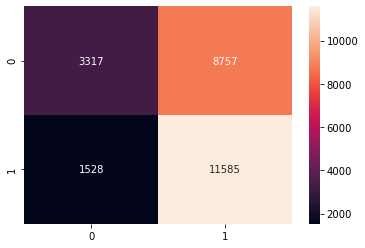

              precision    recall  f1-score   support

           0       0.68      0.27      0.39     12074
           1       0.57      0.88      0.69     13113

    accuracy                           0.59     25187
   macro avg       0.63      0.58      0.54     25187
weighted avg       0.62      0.59      0.55     25187

朴素贝叶斯测试集准确率为： 0.591654424901735
朴素贝叶斯训练集准确率为： 0.6041424033880359


In [30]:
#用朴素贝叶斯完成中文文本分类器
from sklearn.naive_bayes import MultinomialNB
review_classifier = MultinomialNB()
review_classifier.fit(Xtrain,y_train)

# 对测试集的样本进行预测
y_pred = review_classifier.predict(Xtest)
confusion_matrix(y_test, y_pred) # 混淆矩阵

colorMetrics = confusion_matrix(y_test, y_pred)
sns.heatmap(colorMetrics,annot=True,fmt='d')
plt.show()

# 分类报告
# 给出每个类的准确率，召回率和F值，以及这三个参数
print(classification_report(y_test,y_pred)) 

print("朴素贝叶斯测试集准确率为：", accuracy_score(y_test, y_pred))

score1 = cross_val_score(review_classifier,Xtrain,y_train,cv=10,scoring="accuracy").mean()
print("朴素贝叶斯训练集准确率为：", score1)


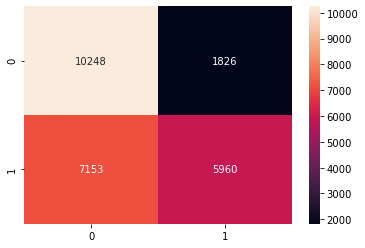

逻辑回归预测测试集准确率为： 0.6435065708500417
逻辑回归精确率、召回率、F1-score:
               precision    recall  f1-score   support

           0       0.59      0.85      0.70     12074
           1       0.77      0.45      0.57     13113

    accuracy                           0.64     25187
   macro avg       0.68      0.65      0.63     25187
weighted avg       0.68      0.64      0.63     25187



In [31]:
# 用逻辑回归完成中文文本分
from sklearn.linear_model import LogisticRegression  

LR_model = LogisticRegression(penalty='l2',max_iter=3000)  
LR_model.fit(Xtrain,y_train)

# 对测试集的样本进行预测
y_pred = LR_model.predict(Xtest)
confusion_matrix(y_test, y_pred) # 混淆矩阵

colorMetrics = confusion_matrix(y_test, y_pred)
sns.heatmap(colorMetrics,annot=True,fmt='d')
plt.show()

print("逻辑回归预测测试集准确率为：", LR_model.score(Xtest, y_test))

# 给出每个类的准确率，召回率和F值，以及这三个参数
print("逻辑回归精确率、召回率、F1-score:\n", classification_report(y_test, y_pred))


In [32]:
# 利用支持向量机（SVM）来做情感分析预测
from sklearn import svm

训练数据上的准确率为：0.7740206458443621
测试数据上的准确率为: 0.6409655774804462


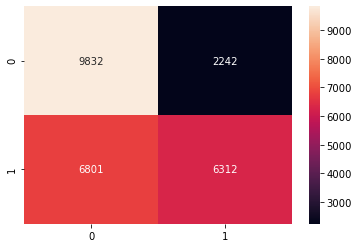

逻辑回归精确率、召回率、F1-score:
               precision    recall  f1-score   support

           0       0.59      0.81      0.68     12074
           1       0.74      0.48      0.58     13113

    accuracy                           0.64     25187
   macro avg       0.66      0.65      0.63     25187
weighted avg       0.67      0.64      0.63     25187



In [33]:
# TODO: 初始化SVM模型，并利用模型的fit函数来做训练并打印在训练和测试数据上的准确率，SVM模型的kernel设置成“rbf”核函数
svc = svm.SVC(kernel='rbf').fit(Xtrain,y_train)
# 打印在训练数据上的准确率
print ("训练数据上的准确率为：" + str(svc.score(Xtrain, y_train)))
# 打印在测试数据上的准确率
print ("测试数据上的准确率为: " + str(svc.score(Xtest, y_test)))

y_pred = svc.predict(Xtest)
confusion_matrix(y_test, y_pred) # 混淆矩阵

colorMetrics = confusion_matrix(y_test, y_pred)
sns.heatmap(colorMetrics,annot=True,fmt='d')
plt.show()

# 给出每个类的准确率，召回率和F值，以及这三个参数
print("逻辑回归精确率、召回率、F1-score:\n", classification_report(y_test, y_pred))


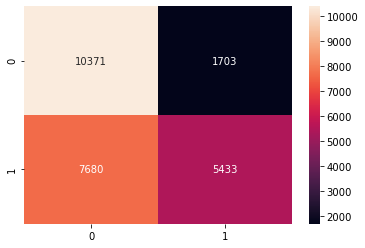

随机森林预测测试集准确率为： 0.6435065708500417
随机森林精确率、召回率、F1-score:
               precision    recall  f1-score   support

           0       0.57      0.86      0.69     12074
           1       0.76      0.41      0.54     13113

    accuracy                           0.63     25187
   macro avg       0.67      0.64      0.61     25187
weighted avg       0.67      0.63      0.61     25187



In [34]:
# 用随机森林完成中文文本分类
Clf_model = RandomForestClassifier()
Clf_model.fit(Xtrain, y_train)

# 对测试集的样本进行预测
y_pred = Clf_model.predict(Xtest)
confusion_matrix(y_test, y_pred)  # 混淆矩阵

colorMetrics = confusion_matrix(y_test, y_pred)
sns.heatmap(colorMetrics,annot=True,fmt='d')
plt.show()

print("随机森林预测测试集准确率为：", LR_model.score(Xtest, y_test))

# 给出每个类的准确率，召回率和F值，以及这三个参数
print("随机森林精确率、召回率、F1-score:\n", classification_report(y_test, y_pred))
